# Imports

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

# Import base models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Set random seed
np.random.seed(42)


# Loading the Datasets

In [3]:
# Load the datasets
frequency_encoded = pd.read_csv('Data/Processed Data/frequency_encoded_data.csv')
one_hot_encoded = pd.read_csv('Data/Processed Data/one_hot_encoded_data.csv')
target_encoded = pd.read_csv('Data/Processed Data/target_encoded_data.csv')

# Initialize dictionaries
datasets = {
    'Frequency Encoded': frequency_encoded,
    'One-Hot Encoded': one_hot_encoded,
    'Target Encoded': target_encoded
}

meta_results = {
    'Frequency Encoded': {},
    'One-Hot Encoded': {},
    'Target Encoded': {}
}

# MetaLearning

## Base Models

In [4]:
base_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

In [5]:
meta_clf = LogisticRegression(
    random_state=42,
    class_weight={0: 1, 1: 12}  
)

def get_meta_features(models, X, y, cv=5):
    meta_features = np.zeros((X.shape[0], len(models)))
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for model_idx, model in enumerate(models.values()):
        temp_meta = np.zeros(X.shape[0])
        
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Apply SMOTE to training data
            smote = ADASYN(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            
            # Train model
            model.fit(X_train_resampled, y_train_resampled)
            temp_meta[val_idx] = model.predict_proba(X_val)[:, 1]
                
        meta_features[:, model_idx] = temp_meta
    
    return meta_features


In [6]:
for encoding in datasets.keys():
    X = datasets[encoding].drop(columns=['Class/ASD'])
    y = datasets[encoding]['Class/ASD']
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Generate meta-features
    meta_features = get_meta_features(base_models, X, y)
    
    # Split meta-features
    meta_train, meta_test = meta_features[X_train_orig.index], meta_features[X_test_orig.index]
    
    # Apply SMOTE to meta-features
    smote = ADASYN(random_state=42)
    meta_train_smote, y_train_smote = smote.fit_resample(meta_train, y_train_orig)
    
    # Initialize results structure for current encoding
    meta_results[encoding] = {}
    
    # Setup cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Before SMOTE evaluation
    kfold_scores = cross_val_score(meta_clf, meta_train, y_train_orig, cv=cv, scoring='f1')
    f1 = kfold_scores.mean()
    
    # Train meta-classifier on original data
    meta_clf.fit(meta_train, y_train_orig)
    y_proba = meta_clf.predict_proba(meta_test)[:, 1]
    
    meta_results[encoding]["before smote"] = {
        "f1_score(CV)": f1,
        "y_test": y_test_orig,
        "y_proba": y_proba
    }
    
    # After SMOTE evaluation
    smote_pipeline = Pipeline([
        ('smote', ADASYN(random_state=42)),
        ('meta_clf', LogisticRegression(random_state=42))
    ])
    
    kfold_scores = cross_val_score(smote_pipeline, meta_train, y_train_orig, cv=cv, scoring='f1')
    f1 = kfold_scores.mean()
    
    # Train final meta-classifier with SMOTE
    meta_clf.fit(meta_train_smote, y_train_smote)
    y_proba = meta_clf.predict_proba(meta_test)[:, 1]
    
    meta_results[encoding]["after smote"] = {
        "f1_score(CV)": f1,
        "y_test": y_test_orig,
        "y_proba": y_proba
    }

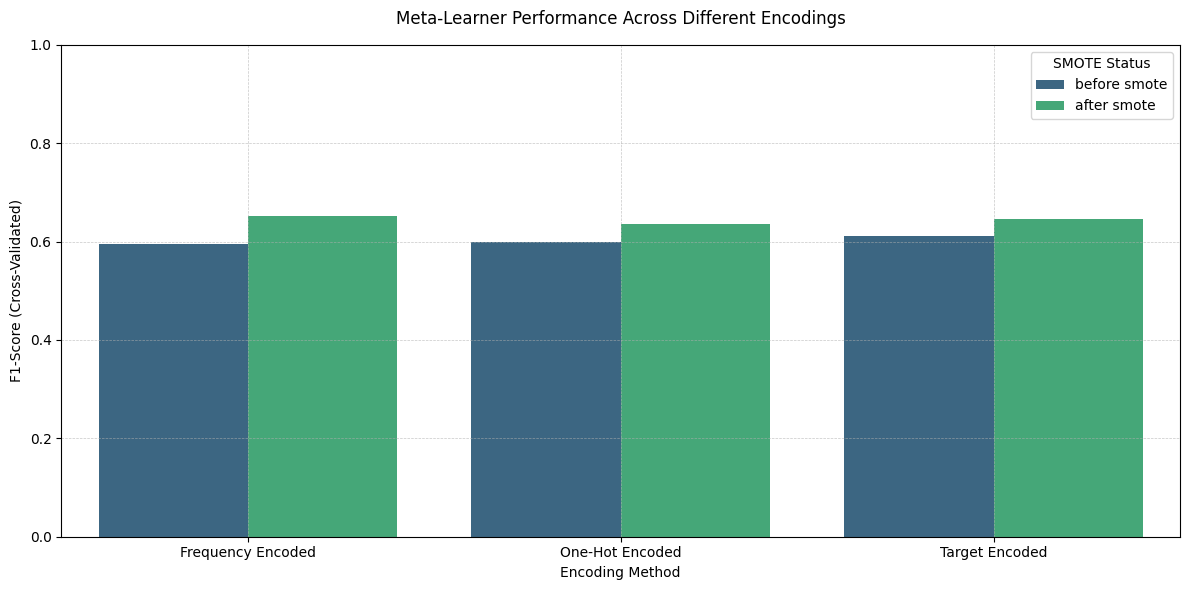


Detailed F1-Scores:
Encoding      Frequency Encoded  One-Hot Encoded  Target Encoded
SMOTE                                                           
after smote              0.6523           0.6363          0.6468
before smote             0.5959           0.5995          0.6117


In [7]:
# Prepare data for plotting
plot_data = []
for encoding in meta_results.keys():
    for smote_status in ['before smote', 'after smote']:
        plot_data.append({
            'Encoding': encoding,
            'SMOTE': smote_status,
            'F1-Score': meta_results[encoding][smote_status]['f1_score(CV)']
        })

df_plot = pd.DataFrame(plot_data)

# Create visualization
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Create bar plot
sns.barplot(
    data=df_plot,
    x='Encoding',
    y='F1-Score',
    hue='SMOTE',
    palette='viridis'
)

# Customize plot
plt.title('Meta-Learner Performance Across Different Encodings', pad=15)
plt.xlabel('Encoding Method')
plt.ylabel('F1-Score (Cross-Validated)')

# Add grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_ylim(0, 1)

# Adjust legend
plt.legend(title='SMOTE Status')

plt.tight_layout()
plt.show()

# Print numerical results
print("\nDetailed F1-Scores:")
pivot_table = df_plot.pivot(index='SMOTE', columns='Encoding', values='F1-Score')
print(pivot_table.round(4))

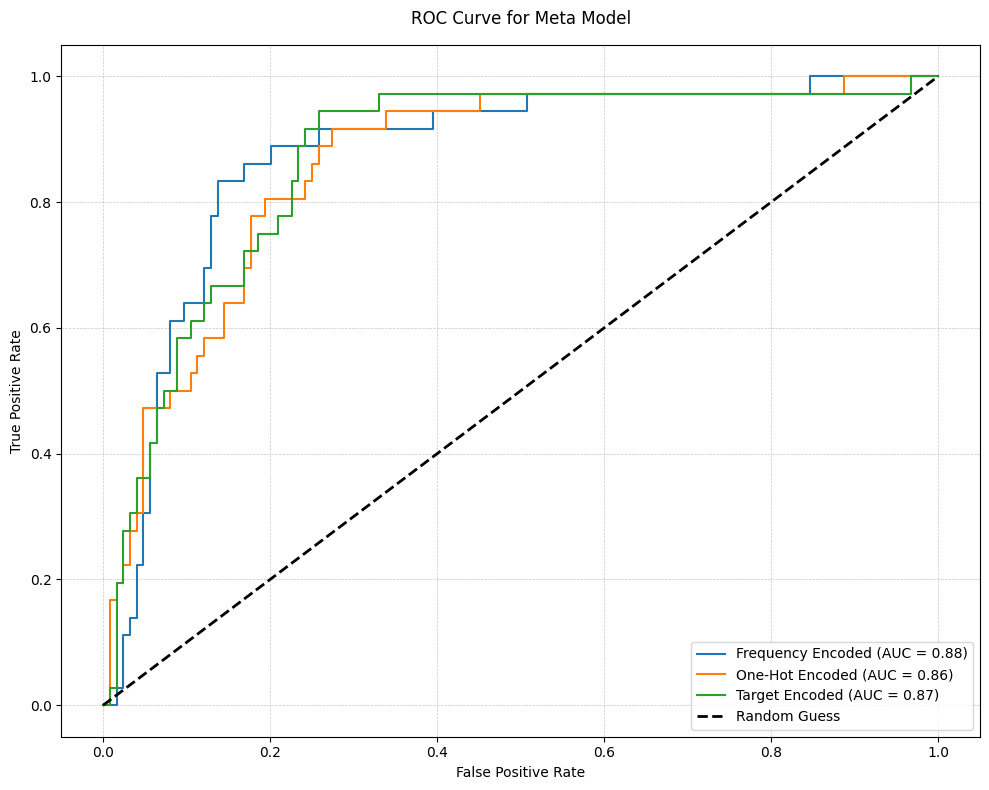

In [8]:
# Plot ROC curve for each encoding
plt.figure(figsize=(10, 8))

for encoding in meta_results.keys():
    y_test = meta_results[encoding]["after smote"]["y_test"]
    y_proba = meta_results[encoding]["after smote"]["y_proba"]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{encoding} (AUC = {roc_auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

# Customize plot
plt.title('ROC Curve for Meta Model', pad=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()